In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

In [63]:
data = pd.read_csv("./data/augmented_data.csv")

In [64]:
data.nunique()

period                     5
minute                   139
possession               290
duration               78058
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               702
location_y_distance      472
technique                  7
body_part                  4
type                       5
is_penalty                 2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11912
pass_angle             10519
pass_type                  8
pass_height                4
pass_length             9930
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45564
statsbomb_xg           82551
end_location_x           376
end_location_y           705
is_goal       

In [65]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.059608
defenders_triangle     0.040313
location_x_distance    0.036467
goalkeeper_x           0.028578
defenders_3m_radius    0.024476
location_y_distance    0.022575
goalkeeper_y           0.021707
duration               0.021587
is_penalty             0.016024
shot_angle             0.014185
open_goal              0.012089
pass_length            0.010934
pass_duration          0.009548
period                 0.008684
good_foot              0.006569
first_time             0.005197
num_passes             0.005003
pass_angle             0.004141
under_pressure         0.004035
one_on_one             0.003981
possession             0.001665
minute                 0.001327
aerial_won             0.001312
follows_dribble        0.000000
dtype: float64

In [66]:
# drop redundant features
data.drop(["location_x", "location_y"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["shot_angle", "duration"], axis=1, inplace=True)
# drop low information features
data.drop(["aerial_won", "follows_dribble", "possession", "minute", "period", "num_passes", "pass_duration", "pass_height", "pass_type", "type"], axis=1, inplace=True)
# "position", "body_part", "type", "pass_height", "pass_type"

In [67]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "position", "body_part"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [68]:
data.nunique()

location_x_distance           635
location_y_distance           472
is_penalty                      2
first_time                      2
open_goal                       2
                             ... 
position_Secondary Striker      2
body_part_Head                  2
body_part_Left Foot             2
body_part_Other                 2
body_part_Right Foot            2
Length: 64, dtype: int64

In [69]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [70]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84065 entries, 0 to 84064
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location_x_distance                 84065 non-null  float64
 1   location_y_distance                 84065 non-null  float64
 2   is_penalty                          84065 non-null  bool   
 3   first_time                          84065 non-null  bool   
 4   open_goal                           84065 non-null  bool   
 5   one_on_one                          84065 non-null  bool   
 6   under_pressure                      84065 non-null  bool   
 7   pass_angle                          84065 non-null  float64
 8   pass_length                         84065 non-null  float64
 9   defenders_3m_radius                 84065 non-null  int64  
 10  defenders_triangle                  84065 non-null  int64  
 11  goalkeeper_x                        84065

In [72]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [73]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.32).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [74]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [75]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [76]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [77]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [78]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=50, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [79]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.10, max_depth=12, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [80]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.04949053814130655
Root Mean Squared Error: 0.07665939758483253
R-squared (R2 Score): 0.7392333540212414


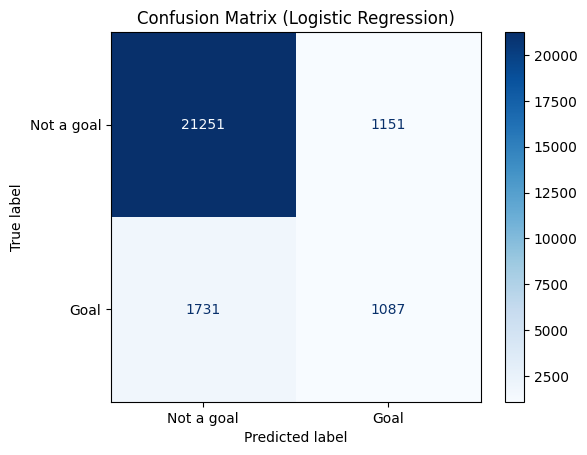


Logistic Regression
Accuracy: 0.8857256145915939
Precision: 0.48570151921358357
Recall: 0.3857345635202271
F1: 0.4299841772151899


In [81]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

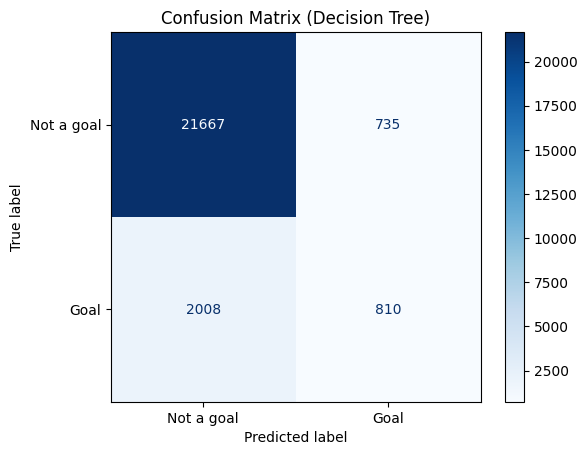


Decision Tree
Accuracy: 0.8912371134020619
Precision: 0.5242718446601942
Recall: 0.28743789921930446
F1: 0.3713041485216594


In [82]:
dt_xg, viz = decision_tree()

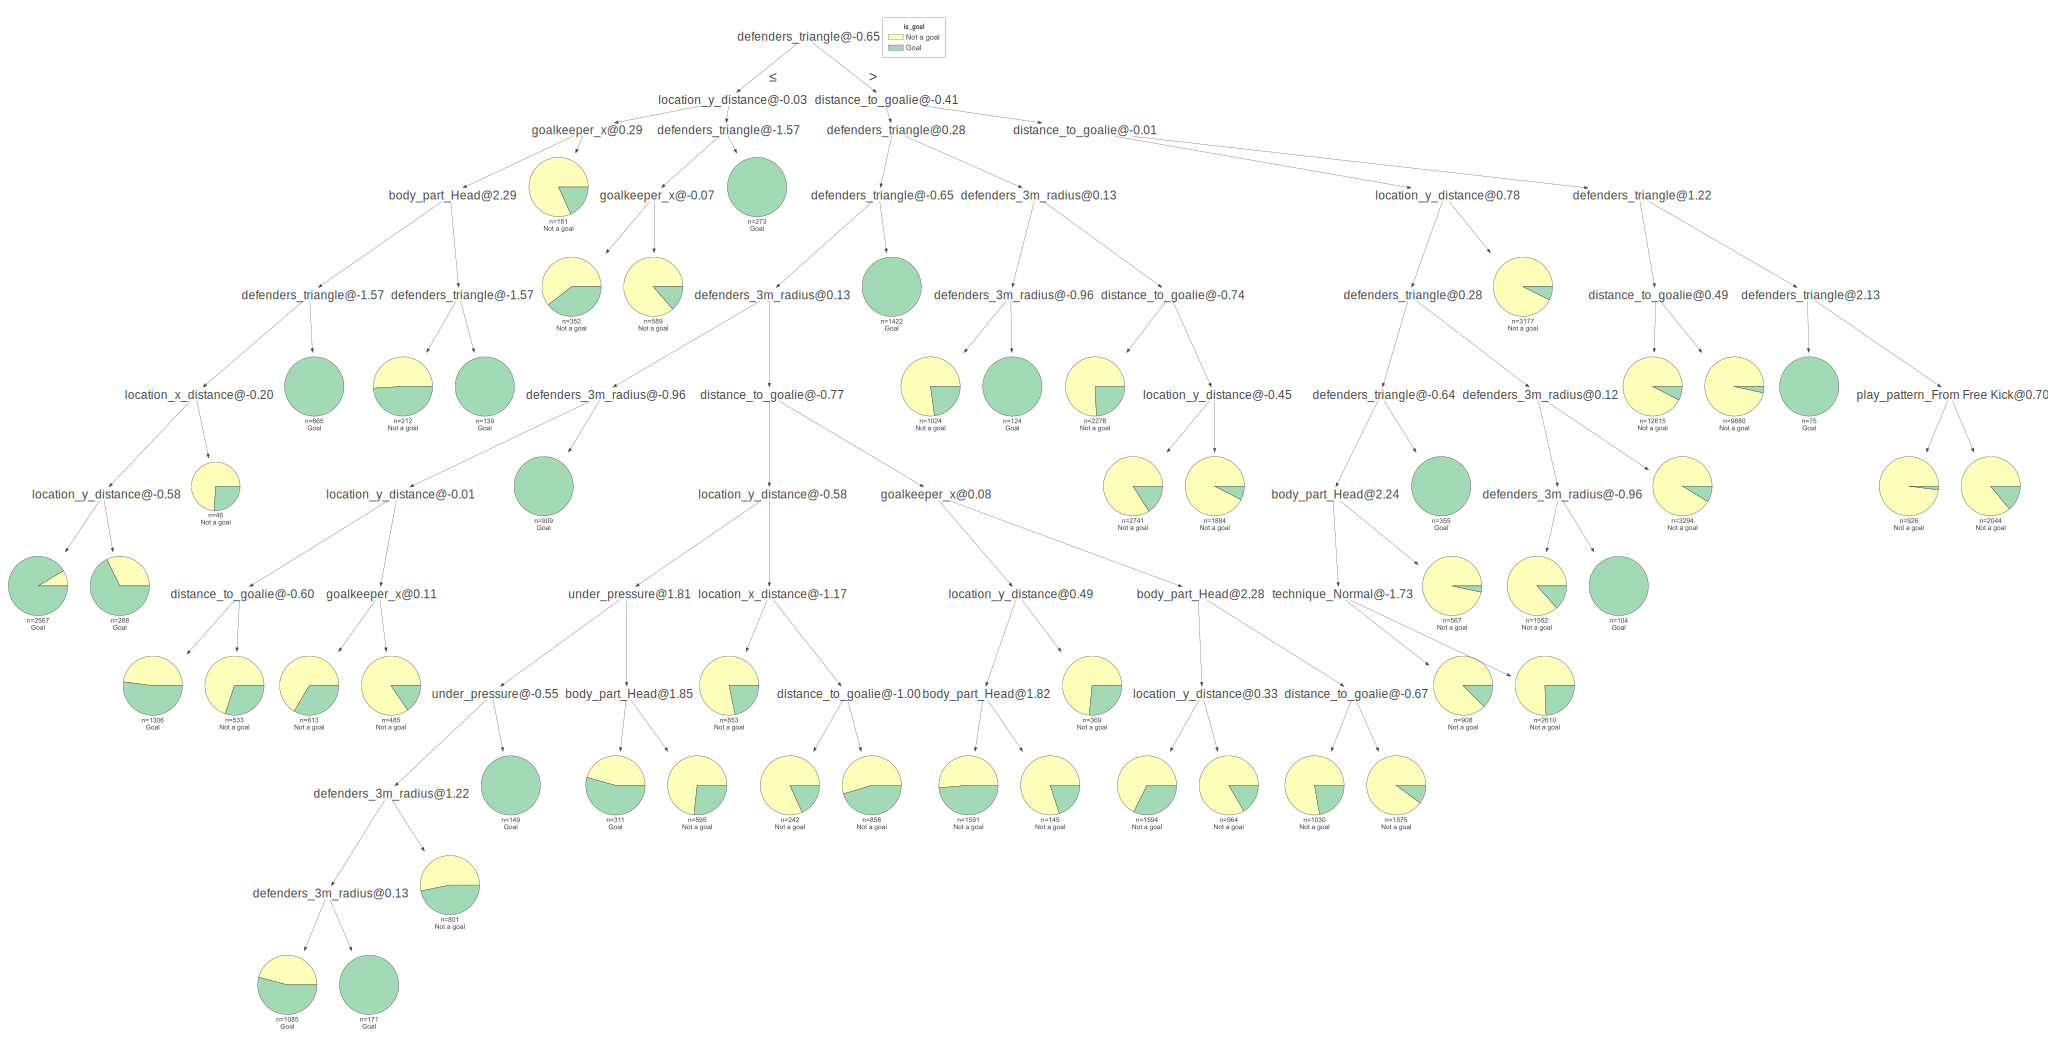

In [83]:
viz.view(fancy=False)

In [ ]:
gbt_xg = gradient_boosted_tree()

In [ ]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.20))
calculate_stats(y_test, sb_pred, "StatsBomb")

In [ ]:
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

In [ ]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.24) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [ ]:
diff = gbt_pred - y_test
data_copy.iloc[diff[diff == -1].index].sort_values(by=["statsbomb_xg"])

In [ ]:
diff_sb = sb_pred - y_test
data_copy.iloc[diff_sb[diff_sb == -1].index].sort_values(by=["statsbomb_xg"])

In [ ]:
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy, y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg
data_copy_test.sort_values(by=["diff"])

In [ ]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()